In [1]:
# Cell 1: Imports and load dataset
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt

# NLP
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load dataset (change filename if needed)
df = pd.read_csv("HRAST.csv")
print("Loaded:", df.shape)
print(df.columns)
df.head()


[nltk_data] Downloading package stopwords to C:\Users\shashank A
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\shashank A
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to C:\Users\shashank A
[nltk_data]     U\AppData\Roaming\nltk_data...


Loaded: (23113, 28)
Index(['id', 'review', 'Unnamed: 2', 'positive', 'negative', 'neutral',
       'Clean', 'Comfort', 'Facilities/Amenities', 'Location',
       'Restaurant (dinner)', 'Staff', 'View (Balcony)', 'Breakfast', 'Room',
       'Pool', 'Beach', 'Bathroom/Shower (toilet)', 'Bar', 'Bed', 'Parking',
       'Noise', 'Reception-checkin', 'Lift', 'Value for money', 'Wi-Fi',
       'Generic', 'Aspect'],
      dtype='object')


,id,review,Unnamed: 2,positive,negative,neutral,Clean,Comfort,Facilities/Amenities,Location,...,Bar,Bed,Parking,Noise,Reception-checkin,Lift,Value for money,Wi-Fi,Generic,Aspect
0,1,1 elevator not working.,NaN,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1 euros to park per day on their own premises.,NaN,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,3,1 hour queue to check-in.,NaN,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,1 min walk to metro entrance and also few min ...,NaN,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,1 minute walk from the main metro & train stat...,NaN,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Cell 2: Keep only relevant columns and create 'data' DataFrame
# Adjust column names if they differ in your CSV
# Expected columns: 'review', 'positive', 'negative', 'neutral' (as in your notebook)
data = df.copy()

# If your file already had only needed columns, this is safe. Otherwise, uncomment and select precise columns:
# data = df[['review','positive','negative','neutral']].copy()

# Preview
print(data.shape)
data.head()


(23113, 28)


,id,review,Unnamed: 2,positive,negative,neutral,Clean,Comfort,Facilities/Amenities,Location,...,Bar,Bed,Parking,Noise,Reception-checkin,Lift,Value for money,Wi-Fi,Generic,Aspect
0,1,1 elevator not working.,NaN,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1 euros to park per day on their own premises.,NaN,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,3,1 hour queue to check-in.,NaN,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,1 min walk to metro entrance and also few min ...,NaN,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,1 minute walk from the main metro & train stat...,NaN,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Cell 3: Build a 'sentiment' label from positive/negative/neutral columns
# This logic assumes positive/negative/neutral are numeric indicators or scores.
def assign_sentiment(row):
    # If columns are binary indicators (0/1) or scores
    if 'positive' in row and 'negative' in row and 'neutral' in row:
        # choose the max score column
        vals = {'positive': row['positive'], 'negative': row['negative'], 'neutral': row['neutral']}
        # If ties or all NaN -> unknown
        if any(pd.isna(v) for v in vals.values()):
            return 'unknown'
        # pick argmax
        label = max(vals, key=vals.get)
        return label
    else:
        return 'unknown'

# Create sentiment column if not present
if 'sentiment' not in data.columns:
    data['sentiment'] = data.apply(assign_sentiment, axis=1)

# Drop rows with unknown sentiment or missing review text
data = data.dropna(subset=['review'])
data = data[data['sentiment'] != 'unknown'].reset_index(drop=True)

print("After filtering:", data.shape)
data['sentiment'].value_counts()


After filtering: (23113, 29)


sentiment
positive    11819
negative    10503
neutral       791
Name: count, dtype: int64

In [4]:
# Cell 4: Quick EDA
print("Class distribution:\n", data['sentiment'].value_counts())
print("\nSample reviews:")
display(data[['review','sentiment']].head(5))


Class distribution:
 sentiment
positive    11819
negative    10503
neutral       791
Name: count, dtype: int64

Sample reviews:


,review,sentiment
0,1 elevator not working.,negative
1,1 euros to park per day on their own premises.,neutral
2,1 hour queue to check-in.,negative
3,1 min walk to metro entrance and also few min ...,positive
4,1 minute walk from the main metro & train stat...,positive


In [6]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\shashank A
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\shashank A
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to C:\Users\shashank A
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\shashank A
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
data['cleaned_review'] = data['review'].astype(str).apply(clean_text)


In [8]:
# Cell 5: Text cleaning function and apply
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # remove URLs and emails
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    # remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # tokenize & remove stopwords & lemmatize
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words and len(tok) > 1]
    return " ".join(tokens)

# Apply cleaning (this may take some time)
data['cleaned_review'] = data['review'].astype(str).apply(clean_text)

# Show progress
display(data[['review','cleaned_review']].head(5))


,review,cleaned_review
0,1 elevator not working.,elevator working
1,1 euros to park per day on their own premises.,euro park per day premise
2,1 hour queue to check-in.,hour queue check
3,1 min walk to metro entrance and also few min ...,min walk metro entrance also min walk central ...
4,1 minute walk from the main metro & train stat...,minute walk main metro train station made gett...


In [9]:
# Cell 6: Save the cleaned dataset to CSV
cleaned_csv_name = "cleaned_hotel_reviews.csv"
data.to_csv(cleaned_csv_name, index=False)
print("✅ Cleaned dataset saved as:", cleaned_csv_name)


✅ Cleaned dataset saved as: cleaned_hotel_reviews.csv


In [10]:
# Cell 7: Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # you can adjust max_features
X = tfidf.fit_transform(data['cleaned_review'])
y = data['sentiment']

print("TF-IDF shape:", X.shape)
# Save the vectorizer right away (joblib)
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("✅ TF-IDF vectorizer saved as tfidf_vectorizer.joblib")


TF-IDF shape: (23113, 5000)
✅ TF-IDF vectorizer saved as tfidf_vectorizer.joblib


In [11]:
# Cell 8: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (18490, 5000) Test: (4623, 5000)


In [12]:
# Cell 9: Train a classifier
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300, class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


C:\Users\shashank A U\Downloads\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy: 0.8622106857019252

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.88      0.87      2101
     neutral       0.15      0.15      0.15       158
    positive       0.91      0.89      0.90      2364

    accuracy                           0.86      4623
   macro avg       0.64      0.64      0.64      4623
weighted avg       0.86      0.86      0.86      4623



In [13]:
# Cell 10: Save the trained model with joblib
joblib.dump(model, "sentiment_model.joblib")
print("✅ Model saved as sentiment_model.joblib")


✅ Model saved as sentiment_model.joblib


In [14]:
# Cell 11: Example of loading model and vectorizer for inference
loaded_tfidf = joblib.load("tfidf_vectorizer.joblib")
loaded_model = joblib.load("sentiment_model.joblib")

def predict_sentiment_text(text):
    cleaned = clean_text(text)
    vect = loaded_tfidf.transform([cleaned])
    pred = loaded_model.predict(vect)
    return pred[0]

# Quick demo
print(predict_sentiment_text("I loved the hotel service and the rooms were clean."))
print(predict_sentiment_text("Room was dirty and staff were rude."))


positive
negative


In [15]:
# Cell 12: Organize artifacts into a folder for deployment (optional)
import os
os.makedirs("artifacts", exist_ok=True)
joblib.dump(model, "artifacts/sentiment_model.joblib")
joblib.dump(tfidf, "artifacts/tfidf_vectorizer.joblib")
data.to_csv("artifacts/cleaned_hotel_reviews.csv", index=False)
print("✅ Artifacts saved to ./artifacts/")


✅ Artifacts saved to ./artifacts/


In [16]:
# Cell 13: Streamlit example (copy into your streamlit app file e.g., app.py)
# (NOT to be run in Jupyter — copy-paste to your Streamlit project)
streamlit_code = """
import streamlit as st
import joblib
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load artifacts
model = joblib.load("artifacts/sentiment_model.joblib")
tfidf = joblib.load("artifacts/tfidf_vectorizer.joblib")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_streamlit(text):
    text = text.lower()
    text = re.sub(r'[^a-z\\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

st.title("Hotel Review Sentiment")
user_text = st.text_area("Enter review text")
if st.button("Predict"):
    cleaned = clean_text_streamlit(user_text)
    vect = tfidf.transform([cleaned])
    pred = model.predict(vect)[0]
    st.write("Predicted sentiment:", pred)
"""
print(streamlit_code)



import streamlit as st
import joblib
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load artifacts
model = joblib.load("artifacts/sentiment_model.joblib")
tfidf = joblib.load("artifacts/tfidf_vectorizer.joblib")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_streamlit(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

st.title("Hotel Review Sentiment")
user_text = st.text_area("Enter review text")
if st.button("Predict"):
    cleaned = clean_text_streamlit(user_text)
    vect = tfidf.transform([cleaned])
    pred = model.predict(vect)[0]
    st.write("Predicted sentiment:", pred)



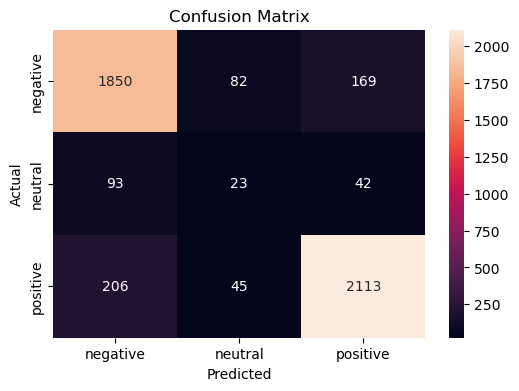

In [17]:
# Cell 14: Confusion matrix for quick visual check
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
